In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import cv2
import torch
from tqdm.auto import tqdm
from PIL import Image
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/train_solution_bounding_boxes .csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [3]:
# get image_id
df['image_id'] = df['image'].apply(lambda x: x.split('.')[0])
df['classes'] = 0
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0


In [4]:
# initialize configuration
img_h, img_w, num_channels = (380, 676, 3)
images_folder = 'data/training_images/'

In [5]:
# convert the data points to YOLO format
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']

In [6]:
# normalize the values
df['x_center'] = df['x_center'] / img_w
df['y_center'] = df['y_center'] / img_h
df['w'] = df['w'] / img_w
df['h'] = df['h'] / img_h
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes,x_center,y_center,w,h
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0,0.100217,0.557191,0.155572,0.129987


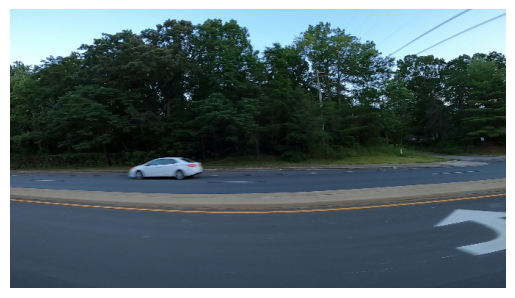

In [7]:
image = random.choice(df['image'])
image_path = os.path.join(images_folder, image)
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)
plt.show()

In [8]:
def draw_bounding_box(idx):
    image = cv2.imread(os.path.join(images_folder, df['image'][idx]))
    x_min = int(df['xmin'][idx])
    y_min = int(df['ymin'][idx])
    x_max = int(df['xmax'][idx])
    y_max = int(df['ymax'][idx])

    # draw the rectangle
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # place the label above bounding boxes
    cv2.putText(image, 'car', (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

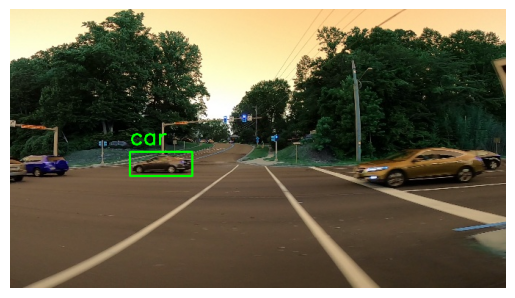

In [9]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

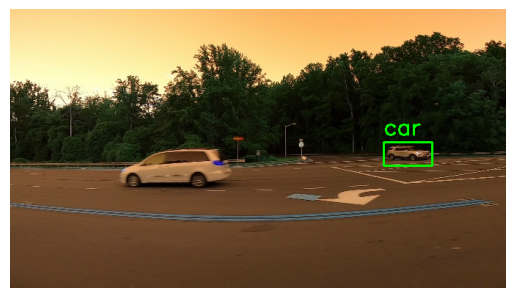

In [10]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

In [11]:
annotations_folder = 'data/annotations/'

if not os.path.exists(annotations_folder):
    os.mkdir(annotations_folder)

In [12]:
annotations_dict = {}

# iterate through dataframe to consolidate bounding boxes for each image
for _, row in df.iterrows():
    image_file = row['image']
    class_label = int(row['classes'])
    x_center = row['x_center']
    y_center = row['y_center']
    w = row['w']
    h = row['h']

    # initialize list if image is not present in dicitionary
    if image_file not in annotations_dict:
        annotations_dict[image_file] = []

    # append annotations to the list 
    annotations_dict[image_file].append(f"{class_label} {x_center} {y_center} {w} {h}")

# write the annotations in text file
for image_file, annotations in annotations_dict.items():
    annotation_file = os.path.join(annotations_folder, os.path.splitext(image_file)[0] + '.txt')
    with open(annotation_file, 'w') as f:
        for annotation in annotations:
            f.write(annotation + '\n')

In [13]:
# split images for training and testing
from sklearn.model_selection import train_test_split
images = list(annotations_dict.keys())
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

In [14]:
# create folders for train and test
train_images_folder = 'datasets/train_images'
test_images_folder = 'datasets/test_images'
train_annotations_folder = 'datasets/train_annotations'
test_annotations_folder = 'datasets/test_annotations'

# create directors for the above paths
'''os.mkdir('datasets')
os.mkdir(train_images_folder)
os.mkdir(test_images_folder)
os.mkdir(train_annotations_folder)
os.mkdir(test_annotations_folder)'''

"os.mkdir('datasets')\nos.mkdir(train_images_folder)\nos.mkdir(test_images_folder)\nos.mkdir(train_annotations_folder)\nos.mkdir(test_annotations_folder)"

In [15]:
def copy_files(images_list, image_src_folder, annotation_src_folder, image_dest_folder, annotation_dest_folder):
    for image_file in images_list:
        # path for source and destination
        src_image_path = os.path.join(image_src_folder, image_file)
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        src_annotations_path = os.path.join(annotation_src_folder, annotation_file)
        dest_image_path = os.path.join(image_dest_folder, image_file)
        dest_annotation_path = os.path.join(annotation_dest_folder, annotation_file)

        # copy images
        shutil.copy2(src_image_path,  dest_image_path)
        # copy annotations
        shutil.copy2(src_annotations_path, dest_annotation_path)

In [16]:
copy_files(train_images, images_folder, annotations_folder, train_images_folder, train_annotations_folder)

copy_files(test_images, images_folder, annotations_folder, test_images_folder, test_annotations_folder)

In [42]:
from ultralytics import YOLO
# load pretrained model
model = YOLO('yolov8n.yaml')

# define training parameters
model.train(data='data.yaml', epochs=55, batch=16, imgsz=676,workers=2)
#model.load('./runs/detect/train/weights/best.pt')

Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=55, time=None, patience=100, batch=16, imgsz=676, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning C:\Users\TANUJ\Downloads\Object Detection\datasets\train_images.cache... 284 images, 0 backgrounds, 0 c
val: Scanning C:\Users\TANUJ\Downloads\Object Detection\datasets\test_images.cache... 71 images, 0 backgrounds, 0 corru


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 704 train, 704 val
Using 2 dataloader workers
Logging results to runs\detect\train4
Starting training for 55 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/55      4.67G      4.736      5.333      4.231         25        704: 100%|██████████| 18/18 [00:44<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/55      4.83G      3.673      4.318      3.924         44        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/55      4.83G      3.066      3.227       3.34         30        704: 100%|██████████| 18/18 [00:46<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/55      4.83G       2.65      2.491      2.746         33        704: 100%|██████████| 18/18 [00:47<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/55      4.83G       2.44      2.288       2.49         31        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/55      4.83G      2.348      2.071      2.355         43        704: 100%|██████████| 18/18 [00:40<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/55      4.85G      2.191      1.874      2.292         39        704: 100%|██████████| 18/18 [00:41<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.455    0.00765     0.0104    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/55      4.83G      2.127      1.705      2.181         25        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.658      0.118      0.192     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/55      4.83G      2.164      1.615      2.176         29        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.762      0.571      0.641      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/55      4.83G      2.105      1.577      2.136         52        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.761      0.639      0.723      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/55      4.83G       1.93      1.446      2.024         30        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.858      0.706      0.856      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/55      4.83G      1.862       1.35      1.961         27        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.907      0.821      0.909      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/55      4.83G      1.906      1.416      2.002         21        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.893      0.807        0.9      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/55      4.83G      1.725      1.227      1.855         35        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.904      0.794      0.893      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/55      4.83G       1.74      1.192      1.837         43        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.942      0.825      0.928      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/55      4.85G      1.663      1.148      1.803         28        704: 100%|██████████| 18/18 [00:41<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all         71        119      0.888      0.882      0.927      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/55      4.83G       1.71      1.146      1.812         39        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.935      0.844      0.928      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/55      4.83G      1.674      1.119      1.788         37        704: 100%|██████████| 18/18 [00:40<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.875      0.874      0.926      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/55      4.83G      1.662      1.059      1.741         21        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.925      0.857      0.931      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/55      4.83G      1.623      1.069      1.742         22        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.955      0.874      0.947       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/55      4.83G      1.572      1.014      1.719         27        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.945      0.875      0.941      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/55      4.83G        1.6      1.015      1.747         34        704: 100%|██████████| 18/18 [00:40<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.955      0.894      0.962      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/55      4.83G       1.59     0.9792       1.73         41        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.961      0.866      0.946      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/55      4.83G      1.534     0.9408      1.644         38        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all         71        119      0.958      0.891      0.945      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/55      4.83G      1.526     0.9176      1.625         33        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.955      0.891      0.954      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/55      4.83G      1.483     0.8876      1.596         29        704: 100%|██████████| 18/18 [00:40<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.983      0.874      0.947      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/55      4.83G      1.529     0.9377       1.66         30        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.988      0.891      0.959      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/55      4.83G      1.522     0.8854      1.621         42        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.968      0.908      0.958      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/55      4.83G      1.553     0.9165      1.638         51        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.925      0.926       0.95      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/55      4.83G      1.484     0.8574      1.623         32        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.965      0.924      0.955      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/55      4.83G      1.482     0.8538      1.582         34        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.948      0.924      0.967      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/55      4.83G      1.434     0.8225      1.584         28        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all         71        119      0.986      0.908       0.96      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/55      4.83G      1.395     0.7866      1.527         28        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119       0.98      0.924      0.958      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/55      4.83G       1.43     0.8056      1.605         34        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.965      0.922      0.957      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/55      4.83G      1.415     0.8109      1.527         41        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.964      0.895      0.965      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/55      4.83G      1.406      0.786      1.545         46        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.964      0.906      0.947       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/55      4.83G      1.393     0.7676      1.523         30        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.973      0.905      0.958      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/55      4.83G      1.359     0.7522      1.509         36        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.981       0.89      0.953      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/55      4.83G      1.405     0.7606      1.526         49        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.975      0.924      0.966       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/55      4.83G      1.405     0.7621      1.518         25        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all         71        119       0.94      0.926      0.964      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/55      4.83G      1.378     0.7399      1.501         35        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.973      0.915      0.961      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/55      4.83G      1.378     0.7508      1.505         32        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.985      0.899      0.959      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/55      4.83G      1.333      0.734      1.464         32        704: 100%|██████████| 18/18 [00:43<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.982      0.894      0.964      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/55      4.85G      1.369     0.7231      1.474         39        704: 100%|██████████| 18/18 [00:41<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.964      0.912      0.962      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/55      4.83G      1.342     0.7146      1.485         38        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.982      0.914      0.967      0.614


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/55      4.83G      1.297     0.7734      1.546         14        704: 100%|██████████| 18/18 [00:39<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.965      0.923      0.966      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/55      4.83G      1.271      0.724      1.499         21        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.968      0.916      0.958      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/55      4.83G      1.273      0.702      1.483         18        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all         71        119      0.991      0.906      0.958      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/55      4.83G      1.274     0.6951      1.492         21        704: 100%|██████████| 18/18 [00:37<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119       0.95      0.953      0.968      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/55      4.83G      1.222     0.6896      1.453         13        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.982       0.93      0.972      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/55      4.83G      1.264     0.6839      1.509         16        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.982      0.917      0.972       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/55      4.83G      1.227     0.6555      1.463         19        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119       0.98      0.916      0.972      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/55      4.83G      1.218     0.6659      1.473         16        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119       0.98      0.924      0.971      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/55      4.83G      1.199     0.6518      1.438         18        704: 100%|██████████| 18/18 [00:38<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.982      0.922      0.972      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/55      4.83G      1.227     0.6722      1.451         15        704: 100%|██████████| 18/18 [00:42<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all         71        119      0.985      0.916      0.973       0.63



55 epochs completed in 0.683 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         71        119      0.985      0.916      0.973      0.629
Speed: 0.4ms preprocess, 4.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002768ACD8AD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [44]:
metrics = model.val()


Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\TANUJ\Downloads\Object Detection\datasets\test_images.cache... 71 images, 0 backgrounds, 0 corru
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<0


                   all         71        119      0.985      0.916      0.973      0.629
Speed: 1.0ms preprocess, 4.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train42



image 1/1 C:\Users\TANUJ\Downloads\Object Detection\datasets\test_images\vid_4_21560.jpg: 416x704 2 cars, 55.5ms
Speed: 4.0ms preprocess, 55.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 704)


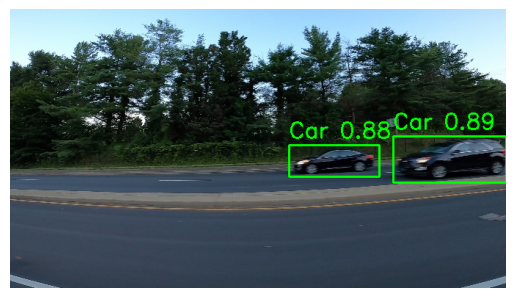

In [46]:
image_path = 'datasets/test_images/vid_4_21560.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()